# <u>NSW DCCEEW training – Demo 5: MODIS time series pre-processing</u>

 - <b>Author</b>: Eric.Lehmann@csiro.au
 - <b>Release date / version</b>: Aug. 2024, v1.0
 - <b>Dev. platform</b>: CSIRO ADIAS/ADS (hub.adias.aquawatchaus.space)
 - <b>Server profile</b>: EASI Open Data Cube No ML &ndash; Version 2023.10.2 
 - <b>Server resources</b>: 32 CPU &ndash; 64GB RAM
 - <b>Python kernel</b>: `Python 3 (ipykernel)`
 - <b>Dask</b>: Local cluster
 
# Overview

This notebook loads up a time series of MODIS data and subsequently applies empirical water quality (WQ) for TSS and Chl-a algorithms to this dataset.

The water quality (TSS, Chl-a) values are then extracted and summarised (averaged) over a small patch of water in front of the selected river mouth. The resulting time series can subsequently written to .csv file.

The MODIS data is loaded from ADIAS: Aqua &ndash; https://explorer.adias.aquawatchaus.space/products/nasa_aqua_l2_oc, and Terra &ndash; https://explorer.adias.aquawatchaus.space/products/nasa_terra_l2_oc.

# User parameters

In [1]:
### Selected river systems: lat/lon locations, names, and sub-catchment names
riv_loc = (151.34428, -33.5677)   # selected location -- river mouth, Haweksbury
csv_file = None   # or output .csv file name to write results to, e.g. "MODIS_data.csv"

latlon_buf = 0.5   # buffer around selected lat/lon location for data load (for visualisation purpose)
# date_range = ('2002-01-01','2025-01-01')   # selected time window ... FULL TIME SERIES
date_range = ('2020-01-01','2025-01-01')   # selected time window ... FULL TIME SERIES

# Number of buffer pixels (MODIS resolution) for various masks
n_pix_dilation = 10   # to select a patch of water around the selected river mouth locations
n_pix_coast_buf = 3   # buffer around the coastline to be removed from above patch

WQparam = 'TSS'   # selected WQ parameter for demo plots

n_workers = None    # for local Dask cluster
# n_workers = 12; workers_mem = 8    # for Dask Gateway cluster

# Notebook setup

In [2]:
### System
import sys, os
import pickle, json
import itertools
import warnings
import logging

### Data handling
import pyproj
import numpy as np
import xarray as xr
import rioxarray
import rasterio
import rasterio.features
import geopandas as gpd
import pandas as pd

### Dask
import dask
from dask.distributed import wait
import dask.array as da

### Display / plots
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

### Data cube
import datacube
# from datacube.utils import masking
# from odc.algo import enum_to_bool
dc = datacube.Datacube(app="AW_AI4M")

Here making use of a couple of functions from the base EASI notebooks &ndash; these can be accessed by `git clone`-ing the following repo: `https://github.com/csiro-easi/easi-notebooks.git`

In [3]:
### Misc
sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')   # standard EASI github repo, cloned from: https://dev.azure.com/csiro-easi/easi-hub-public/_git/hub-notebooks
from app_utils import display_map   # to display the region of interest
import notebook_utils   # for xarray_object_size()

# Eric's own function for getting coastline data:
exec(open("./get_coastline.py").read())

In [4]:
### Filter out following warnings:
# /env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 32.04 MiB.
# This may cause some slowdown. Consider scattering data ahead of time and using futures.
warnings.filterwarnings("ignore", category=UserWarning)

# warnings.resetwarnings()

In [5]:
cmp = LinearSegmentedColormap.from_list("cmp", ["gainsboro", "gainsboro"])   # "dummy" colormap for greyed out land pixels

assert WQparam=='TSS', 'Need to define variables for other WQ parameters...'
WQunits = 'mg/L'         # WQ units
cmap = 'jet'   # if lower_is_better, otherwise: cmap = 'jet_r'
norm = colors.LogNorm()   # if wq_log_scale, otherwise: norm = None

In [6]:
min_longitude = riv_loc[0]-latlon_buf
min_latitude = riv_loc[1]-latlon_buf
max_longitude = riv_loc[0]+latlon_buf
max_latitude = riv_loc[1]+latlon_buf

# Dask

Flexible open-source library for parallel and distributed computing in Python. It provides integration with various Python libraries like NumPy, Pandas, and scikit-learn to enable parallel execution across multiple cores.

In [7]:
### Local Dask cluster
if n_workers is None:  # local Dask cluster using all available CPUs
    
    from dask.distributed import Client, LocalCluster
    # sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
    # import notebook_utils   # for localcluster_dashboard()

    cluster = LocalCluster()
    client = Client(cluster)

    print(f"Local cluster dashboard: {notebook_utils.localcluster_dashboard(client,server='https://hub.adias.aquawatchaus.space')}")
    display(cluster)

### Use the following to shut down this cluster:
# cluster.close()
# client.shutdown()

Local cluster dashboard: https://hub.adias.aquawatchaus.space/user/eric.lehmann/proxy/8787/status


LocalCluster(fb531c25, 'tcp://127.0.0.1:39371', workers=8, threads=32, memory=64.00 GiB)

In [8]:
### Dask Gateway cluster @ n_workers
if n_workers is not None:

    from dask_gateway import Gateway
    gateway = Gateway()
    
    # shutdown_all_clusters...
    clusterRpts = gateway.list_clusters()
    if len(clusterRpts)>0: print(f"Shutting down running clusters:\n {clusterRpts}")
    for cluster in clusterRpts:
        c = gateway.connect(cluster.name)
        c.shutdown()

    print("Creating new Gateway cluster...")

    options = gateway.cluster_options()
    options.node_selection = "worker" 
    options.worker_cores = 8
    options.worker_memory = workers_mem

    cluster = gateway.new_cluster(cluster_options=options)
    cluster.scale(n_workers)
    display( cluster )

    ### Wait for all workers to start
    client = cluster.get_client()
    display( client )
    client.sync( client._wait_for_workers, n_workers=n_workers )

### Use the following to shut down this cluster:
# cluster.shutdown()
# client.close()

In [9]:
display_map(x=(min_longitude,max_longitude), y=(min_latitude,max_latitude))

# Read and pre-process MODIS data

Load and apply standard pre-procsesing steps to the MODIS dataset.

In [10]:
load_bands = ['rrs_443', 'rrs_469', 'rrs_488', 'rrs_547', 'rrs_555', 'l2_flags']

query = { 'product': 'nasa_aqua_l2_oc',                     # MODIS Aqua product
          'measurements': load_bands,
          'x': (min_longitude, max_longitude),    # "x" axis bounds
          'y': (min_latitude, max_latitude),      # "y" axis bounds
          'time': date_range,                     # Any parsable date strings
          'output_crs': 'epsg:4326',              # EPSG code
          # 'resolution': (0.01, 0.01),           # Target resolution
          # 'group_by': 'solar_day',                # Scene ordering  ---  potentially messes up L2 flags with multiple daily observations...!?
          'dask_chunks': {'latitude': -1, 'longitude': -1, 'time': 1} }  # Dask chunks

In [11]:
%%time

### Load MODIS Aqua dataset
data_aqua = dc.load(**query).persist()
display( notebook_utils.xarray_object_size(data_aqua) )
display(data_aqua)
_ = wait(data_aqua)   # actual data loading happens here

'Dataset size: 231.41 MB'

<xarray.Dataset>
Dimensions:      (time: 1699, latitude: 101, longitude: 101)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T03:30:00.751000 ... 2023-10...
  * latitude     (latitude) float64 -34.06 -34.05 -34.04 ... -33.07 -33.06
  * longitude    (longitude) float64 150.8 150.9 150.9 ... 151.8 151.8 151.8
    spatial_ref  int32 4326
Data variables:
    rrs_443      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_469      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_488      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_547      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_555      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    l2_flags     (time, latitude, longitude) int32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

CPU times: user 33.3 s, sys: 1.96 s, total: 35.2 s
Wall time: 1min 57s


In [12]:
%%time

### Load MODIS Terra dataset
query['product'] = 'nasa_terra_l2_oc'   # MODIS Terra product
data_terra = dc.load(**query).persist()
display( notebook_utils.xarray_object_size(data_terra) )
display(data_terra)
_ = wait(data_terra)

'Dataset size: 230.87 MB'

<xarray.Dataset>
Dimensions:      (time: 1695, latitude: 101, longitude: 101)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T00:55:01.240000 ... 2023-10...
  * latitude     (latitude) float64 -34.06 -34.05 -34.04 ... -33.07 -33.06
  * longitude    (longitude) float64 150.8 150.9 150.9 ... 151.8 151.8 151.8
    spatial_ref  int32 4326
Data variables:
    rrs_443      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_469      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_488      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_547      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_555      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    l2_flags     (time, latitude, longitude) int32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

CPU times: user 35.8 s, sys: 1.7 s, total: 37.5 s
Wall time: 2min 22s


In [13]:
assert len(data_aqua.sizes)!=0 and len(data_terra.sizes)!=0, 'One of Aqua and Terra time series is empty.'   # need to update code in this case...
assert data_terra.latitude.identical(data_aqua.latitude), "Different latitude coords"
assert data_terra.longitude.identical(data_aqua.longitude), "Different longitude coords"

In [14]:
%%time

### Combine the Aqua and Terra time series
data = xr.concat([data_aqua, data_terra], dim='time').sortby('time').persist()   # alternatively: xr.merge([data_sst_aqua, data_sst_terra])
display( notebook_utils.xarray_object_size(data) )
display(data)
_ = wait(data)

assert np.all(np.diff(data.time.values).astype(float)>0), "Some time slices are out of order."   # ensure the data is ordered properly temporally

'Dataset size: 462.28 MB'

<xarray.Dataset>
Dimensions:      (time: 3394, latitude: 101, longitude: 101)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T00:55:01.240000 ... 2023-10...
  * latitude     (latitude) float64 -34.06 -34.05 -34.04 ... -33.07 -33.06
  * longitude    (longitude) float64 150.8 150.9 150.9 ... 151.8 151.8 151.8
    spatial_ref  int32 4326
Data variables:
    rrs_443      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_469      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_488      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_547      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    rrs_555      (time, latitude, longitude) int16 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    l2_flags     (time, latitude, longitude) int32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

CPU times: user 14.6 s, sys: 167 ms, total: 14.8 s
Wall time: 14.8 s


In [15]:
%%time

tchks = 256
data = data.chunk(time=tchks).persist()   # re-chunk to sensible chunk sizes (small spatial footprint)
_ = wait(data)

CPU times: user 4.05 s, sys: 210 ms, total: 4.26 s
Wall time: 4.64 s


In [16]:
%%time

### Filter out (int16) 'nodata' pixels --> NaN (float32)
rrs_vars = [bb for bb in list(data.variables) if bb.lower().startswith('rrs')]   # all 'rrs' vars
for vv in rrs_vars:
    nodat = data[vv].attrs['nodata']
    data[vv] = data[vv].where(data[vv]!=nodat)

data = data.persist()
_ = wait(data)

CPU times: user 112 ms, sys: 4.36 ms, total: 116 ms
Wall time: 121 ms


In [17]:
%%time

### Filter data as per the data's L2 flags layer
bad_pixel_flags = ( 'ATMFAIL', 'LAND', 'HIGLINT', 'HTLT', 'HISATZEN', 'STRAYLIGHT', 'CLDICE', 'COCCOLITH',     # PQ-affected pixel categories to filter out. Not used: CHLFAIL, CHLWARN
                    'HISOLZEN', 'LOWLW', 'NAVWARN', 'MAXAERITER', 'ATMWARN', 'SEAICE', 'NAVFAIL', 'nodata' )   # L3 Mask Default from: https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/

fdict = data.l2_flags.attrs['flags_definition']['l2_flags']['values']   # flags dict: '1': 'ATMFAIL', '2': 'LAND', '4': ... etc.
fdict[ str(data.l2_flags.attrs['nodata']) ] = 'nodata'   # also remove L2_flags 'nodata' pixels here

init = True
for kk in fdict:
    if fdict[kk] in bad_pixel_flags:
        msk = ( da.bitwise_and(data.l2_flags,int(kk)) == int(kk) )
        if init: init = False; bad_pixel_mask = msk
        else: bad_pixel_mask = bad_pixel_mask | msk

good_pixel_mask = (~bad_pixel_mask).persist()
_ = wait(good_pixel_mask)

### Apply good pixel mask
data = data.where(good_pixel_mask).persist()
_ = wait(data)

CPU times: user 214 ms, sys: 9.07 ms, total: 223 ms
Wall time: 330 ms


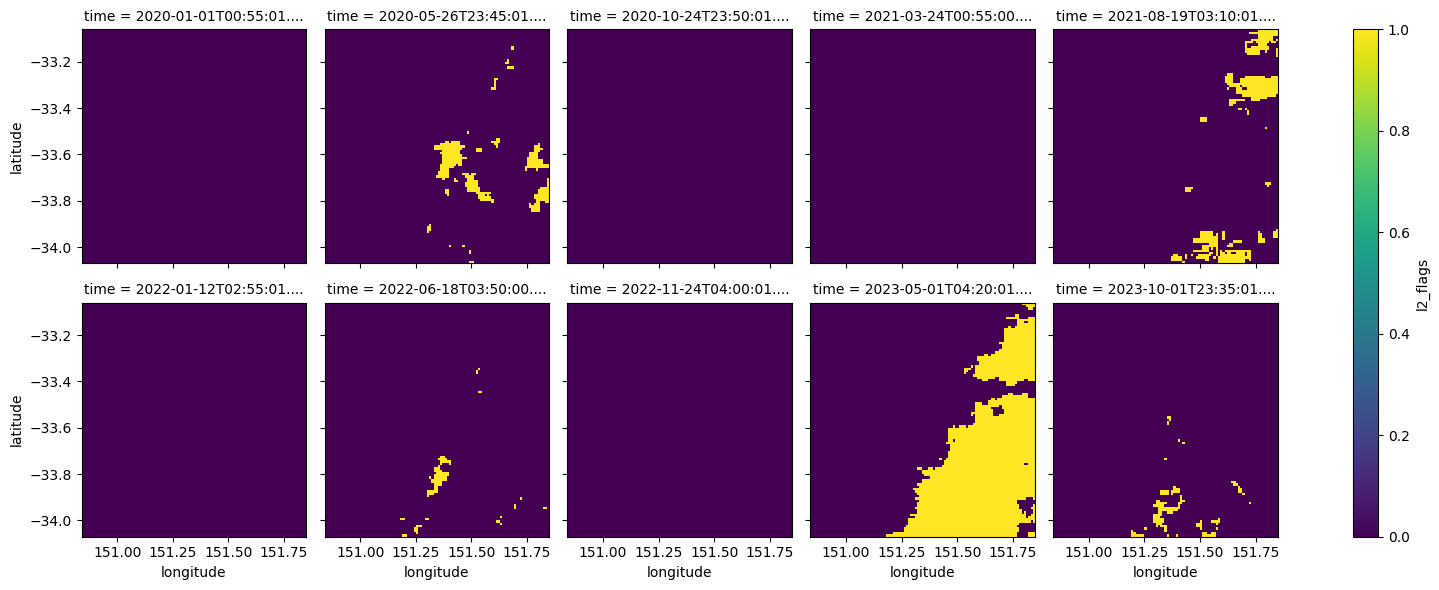

In [18]:
### Visualise some outputs
plt_ind = np.linspace(1, data.sizes['time'], 10, dtype='int') - 1   # some selected time slices to display
good_pixel_mask[plt_ind].plot(col='time', col_wrap=5, figsize=(16,6));

In [19]:
### Apply MODIS band-specific scaling
for vv in rrs_vars:
    add_offset = data[vv].attrs['add_offset']
    scale_fac = data[vv].attrs['scale_factor']
    data[vv] = data[vv] * scale_fac + add_offset

data = data.persist()
_ = wait(data)

In [20]:
### Create mask of positive Rrs values (mask out pixels with negative Rrs values in any band)
for ii,vv in enumerate(rrs_vars):
    if ii==0: rrs_mask = ( data[vv]>=0 )
    else: rrs_mask = rrs_mask & (data[vv]>=0)   #np.logical_and(rrs_mask, data[vv]>=0)

rrs_mask = rrs_mask.persist()
_ = wait(rrs_mask)

### Apply negative-Rrs mask
data = data.where(rrs_mask).persist()
_ = wait(data)

In [21]:
### Drop empty time slices from the dataset
data = data.dropna('time',how='all')
_ = wait(data)
data

<xarray.Dataset>
Dimensions:      (time: 1665, latitude: 101, longitude: 101)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03T23:45:01.737000 ... 2023-10...
  * latitude     (latitude) float64 -34.06 -34.05 -34.04 ... -33.07 -33.06
  * longitude    (longitude) float64 150.8 150.9 150.9 ... 151.8 151.8 151.8
    spatial_ref  int32 4326
Data variables:
    rrs_443      (time, latitude, longitude) float32 dask.array<chunksize=(87, 101, 101), meta=np.ndarray>
    rrs_469      (time, latitude, longitude) float32 dask.array<chunksize=(87, 101, 101), meta=np.ndarray>
    rrs_488      (time, latitude, longitude) float32 dask.array<chunksize=(87, 101, 101), meta=np.ndarray>
    rrs_547      (time, latitude, longitude) float32 dask.array<chunksize=(87, 101, 101), meta=np.ndarray>
    rrs_555      (time, latitude, longitude) float32 dask.array<chunksize=(87, 101, 101), meta=np.ndarray>
    l2_flags     (time, latitude, longitude) float64 dask.array<chunksize=(87, 101, 101), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

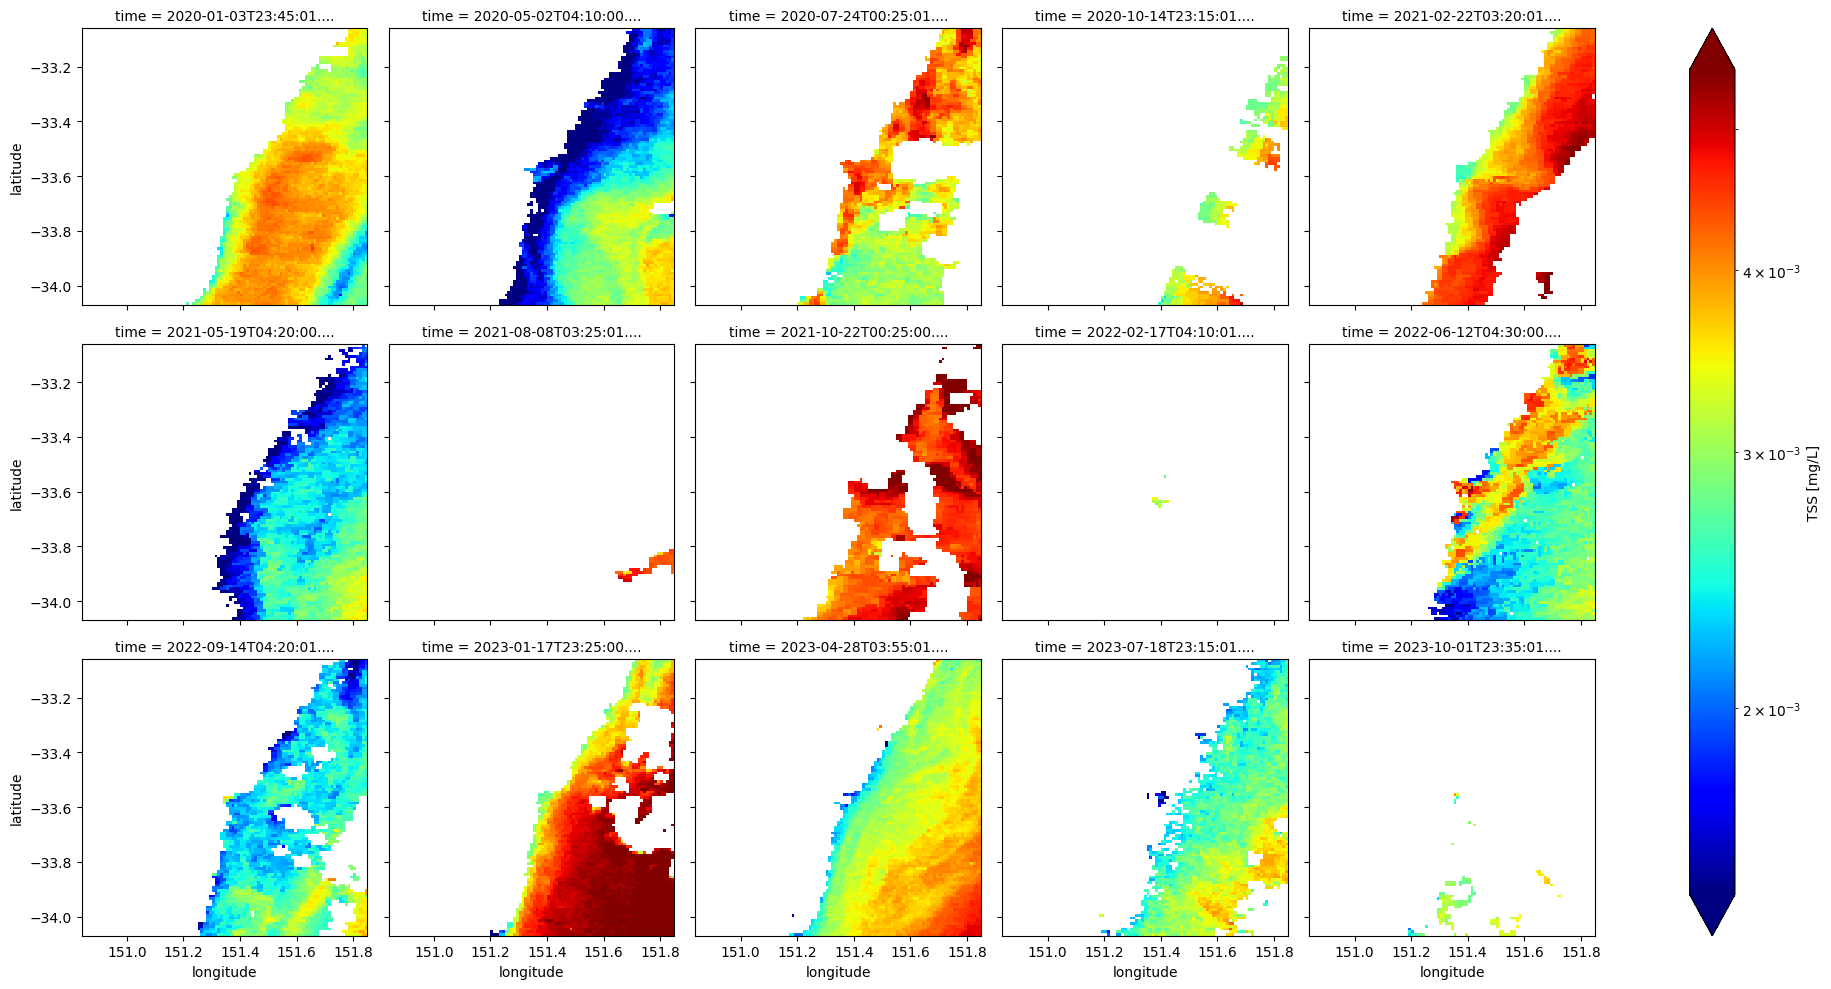

In [22]:
### Some plots to visually check the WQ results
plt_ind = np.linspace(1, data.sizes['time'], 15, dtype='int') - 1   # some selected time slices to display
pp = data.rrs_488[plt_ind].plot( col='time', col_wrap=5, robust=True, norm=norm, cmap=cmap, 
                                  figsize=(20,10), cbar_kwargs={'label':f'{WQparam} [{WQunits}]'} )

At this stage, we have a fully pre-processed dataset of MODIS data (Rrs values i.e. remote sensing reflectance).

# Calculate WQ parameters

Next, we apply a further (custom) scaling factor that will allow us to convert these `Rrs` values to water quality parameters &ndash; note that this next scaling is not something that needs to be applied to the data as a standard MODIS pre-processing step.

In [23]:
### Custom Rrs-specific band scaling ('band values to single wavelength' transform)
scale_fac = 1.2209 
exp_fac = 1.0359

for vv in rrs_vars:
    data[vv] = scale_fac * pow(data[vv], exp_fac)

data = data.persist()
_ = wait(data)

Note that the MODIS-based WQ parameters calculated below are from preliminary empirical CSIRO algorithms and should be used for demo / illustration purposes only.

In [24]:
### Now we can calculate the MODIS-based WQ parameters of interest
band_ratio = data['rrs_469'] / data['rrs_555']   # data['rrs_466'] / data['rrs_554']   # Xarray DataArray
data["TSS"] = (1.3797*pow(band_ratio, -0.938))

# fmax: element-wise maximum of array elements -- NaNs are ignored when possible: if one of the elements being compared is NaN, then the non-nan element is returned
band_ratio = np.fmax(data['rrs_443'], data['rrs_488']) / data['rrs_547']   # np.fmax(data['rrs_442'], data['rrs_488']) / data['rrs_547']
data["Tchl-a"] = (1.2512*pow(band_ratio, -1.694))

data = data.persist()
_ = wait(data)   #progress(data, notebook=False)

/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))


In [25]:
### Remove the Rrs bands -- not needed any longer
data = data.drop_vars(load_bands).persist()
data = data.dropna('time',how='all').chunk(time=tchks).persist()
_ = wait(data)
data

<xarray.Dataset>
Dimensions:      (time: 1665, latitude: 101, longitude: 101)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03T23:45:01.737000 ... 2023-10...
  * latitude     (latitude) float64 -34.06 -34.05 -34.04 ... -33.07 -33.06
  * longitude    (longitude) float64 150.8 150.9 150.9 ... 151.8 151.8 151.8
    spatial_ref  int32 4326
Data variables:
    TSS          (time, latitude, longitude) float32 dask.array<chunksize=(256, 101, 101), meta=np.ndarray>
    Tchl-a       (time, latitude, longitude) float32 dask.array<chunksize=(256, 101, 101), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

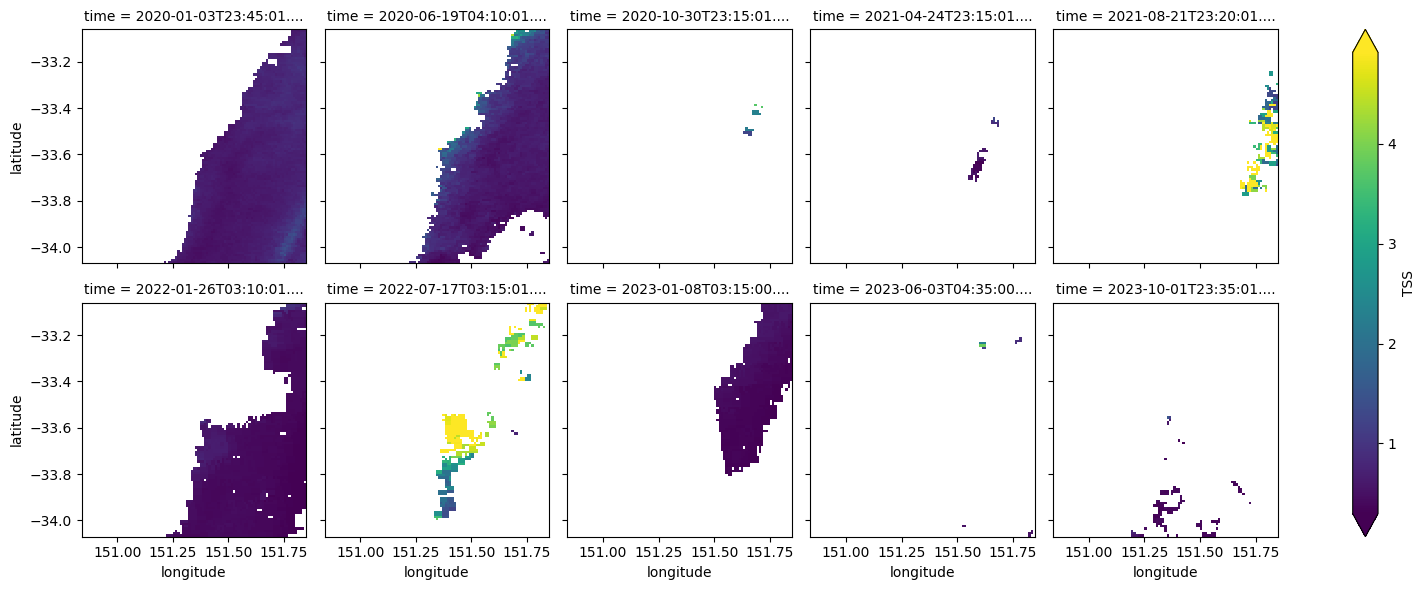

In [26]:
### Some quick plots to double-check raw data
plt_ind = np.linspace(1, data.sizes['time'], 10, dtype='int') - 1   # some selected time slices to display
data.TSS[plt_ind].plot(col='time', col_wrap=5, figsize=(16,6), robust=True);

# Visual checks of WQ parameter dataset

In [27]:
### Generate coastline and land mask for current extents, in projected CRS
land_mask, shp_poly = get_coastline( ds_lon_vec=data.longitude.values, ds_lat_vec=data.latitude.values)   #, do_plot=True)#, buf=0.2 )

## Check time gaps between observations

array([0., 1., 2., 3., 4., 5., 6., 7., 9.])

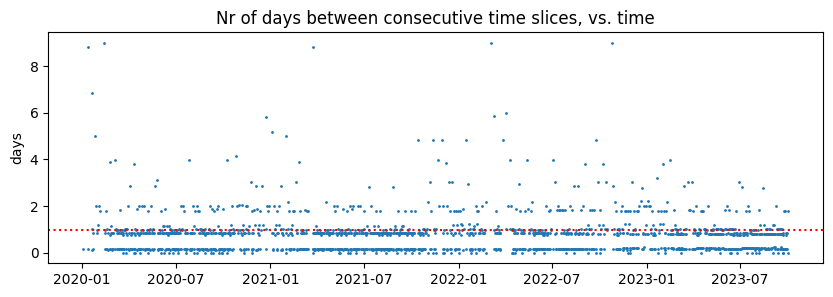

In [28]:
diffvec = np.diff( data.time ) / np.timedelta64(1, 'D')

plt.figure(figsize=(10,3))
plt.plot(data.time.values[1:], diffvec, 'o', markersize=1)
plt.axhline(y=1.0, linestyle=':', color='red')
plt.ylabel('days'); plt.title('Nr of days between consecutive time slices, vs. time');

### Overview of main time gaps in the time series...
np.unique(np.round(diffvec))

Values above `1.0` indicate missing time slices (missing data due to filtered-out pixels). Values below `1.0` **might** indicate multiple time slices per day (or small gaps across midnight)...

## Group all time slices acquired over same day

In [29]:
%%time

### Group by day
tmp = data.time.resample(time='1D')
tmp = tmp.count('time').values   # nr of time slices in each date/group along TS (even where empty / none --> 'nan' count value)
if np.any( ~np.isnan(tmp) & (tmp!=1.) ):   # some time slices less than 1 day apart, i.e. more than 1 time slices per day
    data = data.resample(time='1D', skipna=True).mean('time').persist()   # skipna=True --> still creates empty time slices (one for EACH day along TS)
    data = data.dropna('time',how='all').persist()   # drop them!
    display(data)
    _ = wait(data)

<xarray.Dataset>
Dimensions:      (latitude: 101, longitude: 101, time: 1032)
Coordinates:
  * latitude     (latitude) float64 -34.06 -34.05 -34.04 ... -33.07 -33.06
  * longitude    (longitude) float64 150.8 150.9 150.9 ... 151.8 151.8 151.8
  * time         (time) datetime64[ns] 2020-01-03 2020-01-04 ... 2023-10-01
    spatial_ref  int32 4326
Data variables:
    TSS          (time, latitude, longitude) float32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    Tchl-a       (time, latitude, longitude) float32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

CPU times: user 14 s, sys: 170 ms, total: 14.1 s
Wall time: 14.1 s


array([1., 2., 3., 4., 5., 6., 8., 9.])

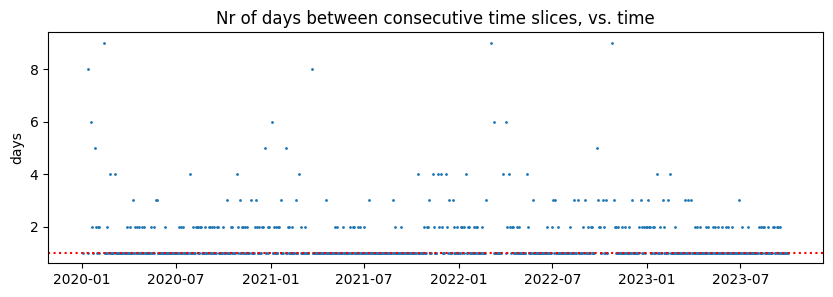

In [30]:
diffvec = np.diff( data.time ) / np.timedelta64(1, 'D')

plt.figure(figsize=(10,3))
plt.plot(data.time.values[1:], diffvec, 'o', markersize=1)
plt.axhline(y=1.0, linestyle=':', color='red')
plt.ylabel('days'); plt.title('Nr of days between consecutive time slices, vs. time');

### Overview of main time gaps in the time series...
np.unique(np.round(diffvec))

## Visualisation

Here using the overall mean and coefficient of variation, for illustration purposes.

In [31]:
### Calculate overall mean and CV
res = data.mean('time')
res = res.where(land_mask).persist()
_ = wait(res)

In [32]:
res2 = data.std('time') / res
res2 = res2.where(land_mask)
res2 = res2.rename_vars({'TSS':'TSS_CV', 'Tchl-a':'Tchl-a_CV'}).persist()
_ = wait(res2)

/env/lib/python3.10/site-packages/dask/array/reductions.py:775: RuntimeWarning: invalid value encountered in subtract
  d = A - u
/env/lib/python3.10/site-packages/dask/array/reductions.py:775: RuntimeWarning: invalid value encountered in subtract
  d = A - u
/env/lib/python3.10/site-packages/dask/array/reductions.py:775: RuntimeWarning: invalid value encountered in subtract
  d = A - u
/env/lib/python3.10/site-packages/dask/array/reductions.py:775: RuntimeWarning: invalid value encountered in subtract
  d = A - u
/env/lib/python3.10/site-packages/dask/array/reductions.py:775: RuntimeWarning: invalid value encountered in subtract
  d = A - u
/env/lib/python3.10/site-packages/dask/array/reductions.py:775: RuntimeWarning: invalid value encountered in subtract
  d = A - u
/env/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invali

In [33]:
res['TSS_CV'] = res2.TSS_CV
res['Tchl-a_CV'] = res2['Tchl-a_CV']
res = res.persist()
_ = wait(res)

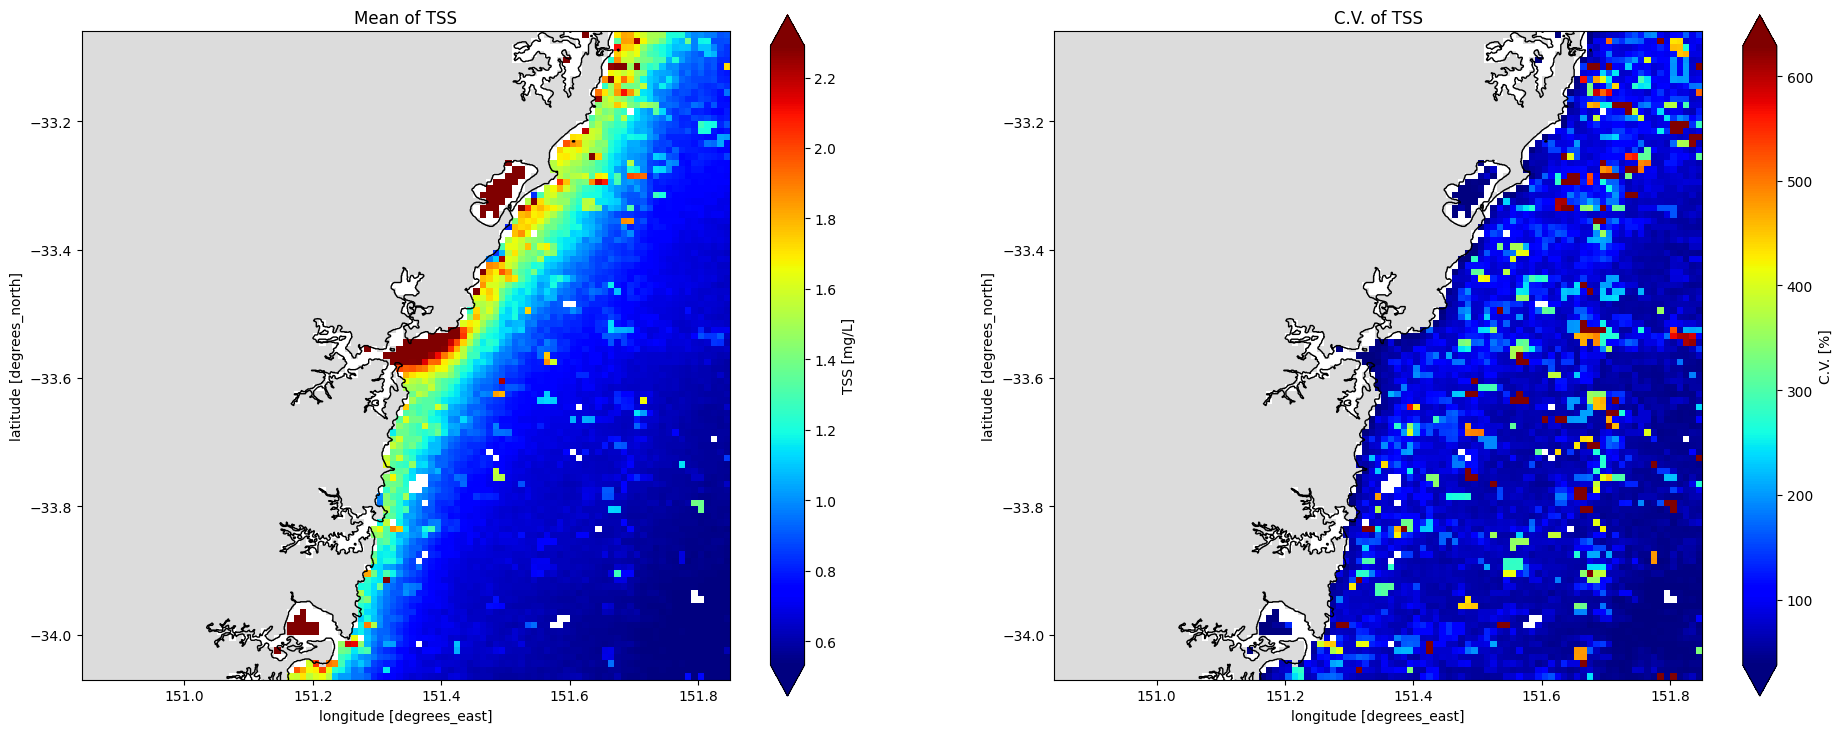

In [34]:
### Plots of results, visual checks
axratio = res.sizes['latitude'] / res.sizes['longitude']   # plot scaling for nice(r) layout
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(23,23*axratio/2.6))   # 2.6 = 2 horizontal plots + some buffer

res[f'{WQparam}'].plot(robust=True, cmap=cmap, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'}, ax=ax1)   # norm=norm, 
ax1.set_title(f"Mean of {WQparam}")
ax1.set_aspect('equal','box')
land_mask.plot(ax=ax1, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax1, color='black', linewidth=1);

(res[f'{WQparam}_CV']*100.).plot(robust=True, cmap="jet", cbar_kwargs={'label':'C.V. [%]'}, ax=ax2)
ax2.set_title(f"C.V. of {WQparam}")
ax2.set_aspect('equal','box')
land_mask.plot(ax=ax2, add_colorbar=False, add_labels=False, cmap=cmp)
shp_poly.boundary.plot(ax=ax2, color='black', linewidth=1);

Inspecting the above plots can provide insight into whether a robust approach is needed for the mean and C.V. calculations.

# Create mask of pixels in front of river mouth

The mask of selected WQ pixels is created from the intersection of:
  - a circle of radius `n_pix_dilation` pixels (Landsat resolution) centred over the selected river mouth location, and
  - the ocean mask (derived from the coastline shape file), eroded by `n_pix_coast_buf` pixels (Landsat resolution) to remove potential artefacts close to the shoreline.

In [35]:
### Binary image dilation function
from scipy import ndimage
from scipy.spatial.distance import pdist

def expand_mask(mask_arr, npix, expand_true=True):
    # Uses the True/False (masked/non-masked) values in the array 'mask_arr' and 
    # expands the True values spatially by 'npix' pixels. The value 'npix' can be
    # non-integer, i.e. the mask can be expanded by any spatial distance.
    # Originally expands True values (when expand_true=True). Can expand False 
    # values by setting expand_true=False.
    nmid = np.floor(npix)
    nmax = int( nmid*2 + 1 )
    struc = np.zeros((nmax, nmax), dtype='bool')
    for ii in range(nmax):   # create desired binary structure for morphological operation
        for jj in range(ii,nmax):
            if pdist( [[nmid,nmid], [ii,jj]] ) <= npix:
                struc[ii,jj] = True
                struc[jj,ii] = True
    if expand_true:
        return ndimage.binary_dilation(mask_arr, structure=struc)
    else:
        return ~ndimage.binary_dilation(~mask_arr.astype(bool), structure=struc)

In [36]:
### ROI mask & example of resulting TSS map (overall mean)

mask = xr.full_like(data.TSS[0],0.0).compute().copy()

### Initialise seed pixel at river loc
xind = np.argmin(abs(mask.longitude-riv_loc[0]).values)
yind = np.argmin(abs(mask.latitude-riv_loc[1]).values)
mask[yind,xind] = 1.0

### Expand mask by selected nr of pixels ... somewhat time consuming
mask2 = expand_mask(mask.values, n_pix_dilation, expand_true=True)
mask.data = mask2

### Create raster mask from coastline polygon
mask2 = rasterio.features.rasterize( ((feat['geometry'], 1) for feat in shp_poly.iterfeatures()),
                                     out_shape = (mask.sizes['latitude'],mask.sizes['longitude']),
                                     transform = data.affine )
mask2 = expand_mask(mask2, n_pix_coast_buf, expand_true=True)
mask2 = xr.DataArray(mask2, coords=(mask.latitude, mask.longitude))

### Combine river mouth area mask and coast mask
mask = mask.where(~mask2.astype('bool'), 0.0)

In [37]:
### Mask WQ time series data
data_msk = data.where(mask)
data_msk = data_msk.dropna('time',how='all').persist()
_ = wait(data_msk)
data_msk

<xarray.Dataset>
Dimensions:      (time: 742, latitude: 101, longitude: 101)
Coordinates:
  * latitude     (latitude) float64 -34.06 -34.05 -34.04 ... -33.07 -33.06
  * longitude    (longitude) float64 150.8 150.9 150.9 ... 151.8 151.8 151.8
  * time         (time) datetime64[ns] 2020-01-03 2020-01-04 ... 2023-10-01
    spatial_ref  int32 4326
Data variables:
    TSS          (time, latitude, longitude) float32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    Tchl-a       (time, latitude, longitude) float32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

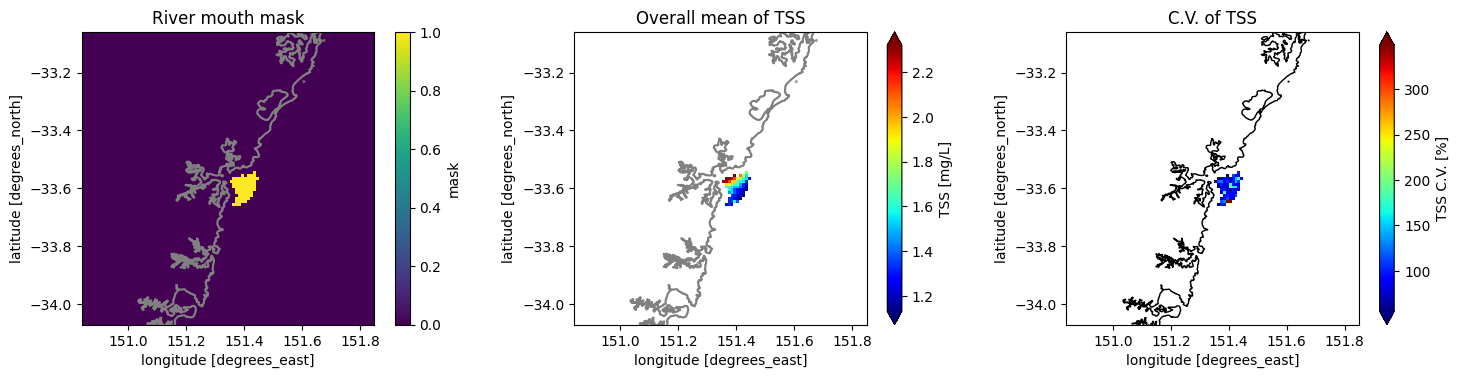

In [38]:
### Plots
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,3.8))

mask.plot(ax=ax1, cbar_kwargs={'label':'mask'})
shp_poly.boundary.plot(ax=ax1, color='grey')
ax1.set_title(f"River mouth mask")
ax1.set_aspect('equal','box')

### Example plot for selected param
data_msk[WQparam].mean('time').plot(robust=True, cmap=cmap, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'}, ax=ax2)   #, norm=norm)
shp_poly.boundary.plot(ax=ax2, color='grey')
ax2.set_title(f"Overall mean of {WQparam}")
ax2.set_aspect('equal','box')

(res[f'{WQparam}_CV'].where(mask)*100.).plot(robust=True, cmap="jet", cbar_kwargs={'label':f'{WQparam} C.V. [%]'}, ax=ax3)
ax3.set_title(f"C.V. of {WQparam}")
ax3.set_aspect('equal','box')
shp_poly.boundary.plot(ax=ax3, color='black', linewidth=1);

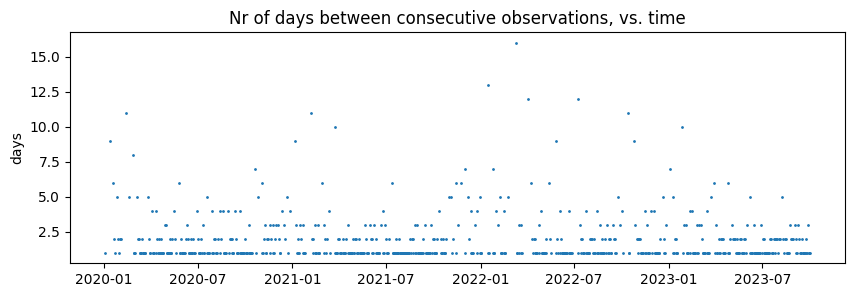

In [39]:
diffvec = np.diff( data_msk.time ) / np.timedelta64(1, 'D')

plt.figure(figsize=(10,3))
plt.plot(data_msk.time.values[1:], diffvec, 'o', markersize=1)
plt.ylabel('days'); plt.title('Nr of days between consecutive observations, vs. time');

# Spatial statistics at river mouth

Here we derive the statistics of interest over all valid pixels spatially (within AOI). We are here not taking the mean and standard deviation due to the potentially "skewed" nature of the distribution of WQ (TSS) values &ndash; large standard deviations can potentially lead to very small, and even negative WQ values corresponding to the bottom of the standard error range (mean minus standard deviation). Such negative values would be physically meaningless, while very small values would lead to issues when plotting the results in a logarithmic scale.

Instead of the mean & st. dev., we here calculate the median (50-th percentile) and inter-quartile range (25-th and 75-th percentiles) of the data.

In [40]:
def qntle_fcn(ds, qnt):   # function applied to each Rrs band (DataArray)
    tmp = ds.chunk(dict(time=-1)).quantile(q=qnt, dim=['longitude','latitude'])
    return tmp

In [41]:
WQlow_quart = data_msk.map(qntle_fcn,qnt=0.25).persist()
WQupp_quart = data_msk.map(qntle_fcn,qnt=0.75).persist()
WQmed_quart = data_msk.map(qntle_fcn,qnt=0.5).persist()
WQmin_quart = data_msk.min(['longitude','latitude']).persist()
WQmax_quart = data_msk.max(['longitude','latitude']).persist()

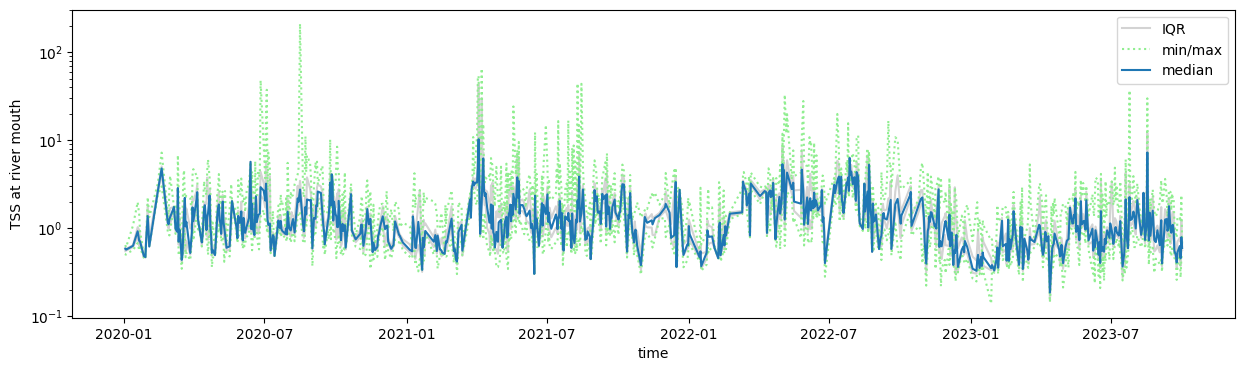

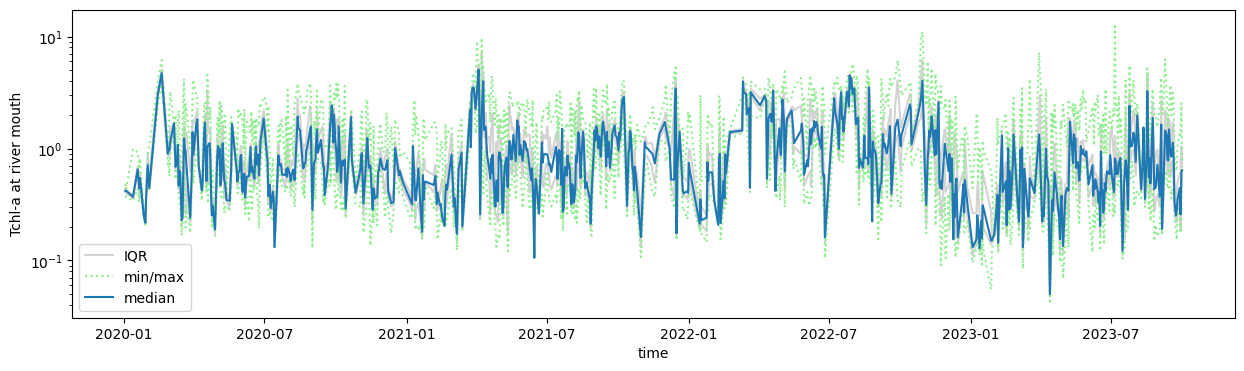

In [42]:
### Plots
for param in ['TSS','Tchl-a']:
    plt.figure(figsize=(15,4))
    plt.gca().plot(WQlow_quart.time, WQlow_quart[param],color='lightgrey', label='IQR')
    plt.gca().plot(WQupp_quart.time, WQupp_quart[param],color='lightgrey')
    plt.gca().plot(WQmin_quart.time, WQmin_quart[param],color='lightgreen', ls=':', label='min/max')
    plt.gca().plot(WQmax_quart.time, WQmax_quart[param],color='lightgreen', ls=':')
    plt.plot(WQmed_quart.time, WQmed_quart[param], label='median')
    plt.gca().set_yscale('log'); plt.gca().legend()
    plt.gca().set_xlabel('time'); plt.gca().set_ylabel(f'{param} at river mouth')
    plt.show()

# Saving average WQ data to .csv file

Calculate the average TSS and Tchl-a at the river mouth and save the time series to .csv file.

In [43]:
data_msk_mean = data_msk.mean(['longitude','latitude']).persist()
data_msk_mean = data_msk_mean.dropna('time',how='all').persist()
data_msk_mean

<xarray.Dataset>
Dimensions:      (time: 742)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03 2020-01-04 ... 2023-10-01
    spatial_ref  int32 4326
Data variables:
    TSS          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Tchl-a       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [44]:
data = { 'date': data_msk_mean.time.dt.date.values, 
         'TSS_mg/litre': data_msk_mean.TSS.values,
         'Tchl-a_ug/litre': data_msk_mean['Tchl-a'].values }
df = pd.DataFrame(data)
display(df)

if csv_file is not None: 
    df.to_csv(csv_file, index=False)

,date,TSS_mg/litre,Tchl-a_ug/litre
0,2020-01-03,0.578059,0.422284
1,2020-01-04,0.568615,0.413717
2,2020-01-13,0.646451,0.402823
3,2020-01-19,0.964548,0.659042
4,2020-01-21,0.832024,0.461915
...,...,...,...
737,2023-09-25,0.605117,0.418654
738,2023-09-28,0.749051,0.602246
739,2023-09-29,0.532273,0.402381
740,2023-09-30,0.961800,0.829019


In [45]:
if n_workers is None:  # local Dask cluster
    cluster.close()
    client.shutdown()
else:   # Gateway cluster
    cluster.shutdown()
    client.close()    

In [46]:
### End notebook.